## RUN ADAPTIVE SAMPLING in a modified version of the Schutte potential (Schutte et al. JCP 2011).

Instead of running new simulations in each epoch, parts from a reference long trajectory are employed. We test different scoring functions; namely, 'counts', 'populations', 'flux imbalance' and 'non-detailed balance'.

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

### Analysis of the potential

In [2]:
h5file = "data/schutte_x05_num1e+08_dt0.0005.h5"
f = h5py.File(h5file, 'r')
data0 = np.array(f['data'])
f.close()
X = data0

In [3]:
X0, X1 = X[:,0], X[:,1]
X.shape, X0.shape, X0[:5]

((50001, 2),
 (50001,),
 array([0.        , 1.00000005, 2.00000009, 3.00000014, 4.00000019]))

Text(0, 0.5, 'PMF')

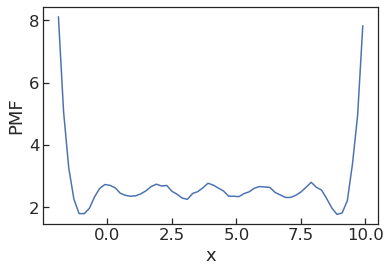

In [7]:
fig, ax = plt.subplots(figsize=(6,4))
hist, bin_edges = np.histogram(X[:,1], bins=np.linspace(-2,10,61), density=True)
bin_centers = [0.5*(bin_edges[i]+bin_edges[i+1]) \
               for i in range(len(bin_edges)-1)]
ax.plot(bin_centers, -np.log(hist),label="x")
ax.set_xlabel('x')
ax.set_ylabel('PMF') #($k_BT$)

In [8]:
assigned_trj = list(np.digitize(X[:,1],bins=bin_edges))

(100.0, 150.0)

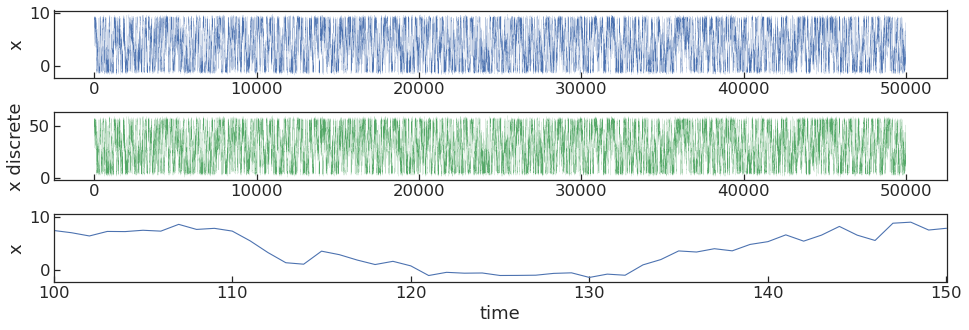

In [9]:
fig,ax=plt.subplots(3,1, figsize=(16,5), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax[0].plot(X[:,0],X[:,1], lw=0.1)
ax[1].step(range(len(assigned_trj)),assigned_trj, color="g", lw=0.1)
ax[-1].set_xlabel('time')
ax[1].set_ylabel('x discrete')
ax[0].set_ylabel('x'), ax[2].set_ylabel('x')
ax[2].plot(X[:,0],X[:,1], lw=1.1)
ax[2].set_xlim(100,150)

MasterMSM: Obtain the reference MSM for later comparisons

In [10]:
from mastermsm.trajectory import traj
distraj = traj.TimeSeries(distraj=assigned_trj, dt=1)
distraj.find_keys()
distraj.keys.sort()

In [11]:
from mastermsm.msm import msm
msm_1D=msm.SuperMSM([distraj], sym=False)

     # states: 60


In [12]:
for lt in [1, 2, 5, 10, 20, 50, 150]: #, 50, 100
    msm_1D.do_msm(lt)
    msm_1D.msms[lt].do_trans(evecs=True)
    msm_1D.msms[lt].boots()

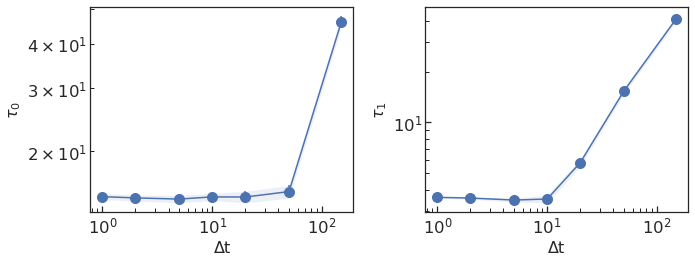

In [13]:
fig,ax=plt.subplots(1,2, figsize=(10,4), sharex=False, sharey=False)
# slowest tau
tau_vs_lagt = np.array([[x,msm_1D.msms[x].tauT[0], msm_1D.msms[x].tau_std[0]] \
               for x in sorted(msm_1D.msms.keys())])
ax[0].errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
#ax.fill_between(10**np.arange(-0.2,3,0.2), 1e-1, 10**np.arange(-0.2,3,0.2), facecolor='lightgray')
ax[0].fill_between(tau_vs_lagt[:,0],tau_vs_lagt[:,1]+tau_vs_lagt[:,2], \
                tau_vs_lagt[:,1]-tau_vs_lagt[:,2], alpha=0.1)
ax[0].set_xlabel(r'$\Delta$t', fontsize=16)
ax[0].set_ylabel(r'$\tau_{0}$', fontsize=16)
#ax.set_xlim(0.8,120)
#ax.set_ylim(2e2,500)
ax[0].set_yscale('log')
ax[0].set_xscale('log')
# 2nd slowest tau
tau_vs_lagt = np.array([[x,msm_1D.msms[x].tauT[1], msm_1D.msms[x].tau_std[1]] \
               for x in sorted(msm_1D.msms.keys())])
ax[1].errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=10)
ax[1].fill_between(tau_vs_lagt[:,0],tau_vs_lagt[:,1]+tau_vs_lagt[:,2], \
                tau_vs_lagt[:,1]-tau_vs_lagt[:,2], alpha=0.1)
ax[1].set_xlabel(r'$\Delta$t', fontsize=16)
ax[1].set_ylabel(r'$\tau_{1}$', fontsize=16)
ax[1].set_yscale('log')
ax[1].set_xscale('log')
plt.tight_layout()

In [14]:
# lag time selection after convergence test
lt = 20

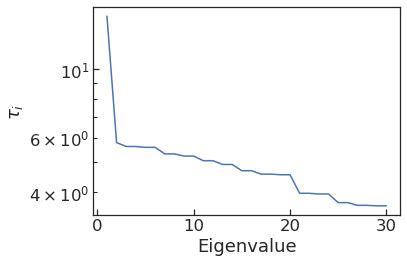

In [15]:
fig, ax = plt.subplots()
ax.plot(range(1,len(msm_1D.msms[lt].tauT)+1),msm_1D.msms[lt].tauT)
#ax.errorbar(range(1,len(msm_1D.msms[lt].tauT)+1),msm_1D.msms[lt].tauT, fmt='o-', \
#            yerr= msm_1D.msms[lt].tau_std, ms=10)
#ax.fill_between(range(1,len(msm_1D.msms[1].tauT)+1), \
#        np.array(msm_1D.msms[lt].tauT)+np.array(msm_1D.msms[lt].tau_std), \
#        np.array(msm_1D.msms[lt].tauT)-np.array(msm_1D.msms[lt].tau_std))
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$')
ax.set_yscale('log')
plt.tight_layout()

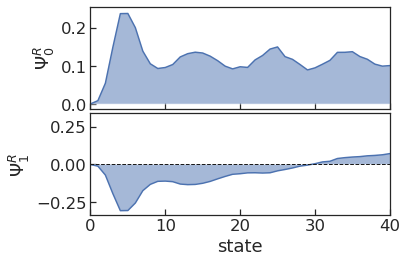

In [16]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
#ax[0].set_ylim(0,0.43)

ax[1].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)
ax[1].set_xlim(0,40)
ax[1].set_xlabel("state")
ax[0].set_ylabel("$\Psi^R_0$")
ax[1].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

Create long trajectory file from which use parts in an artifitial adaptive sampling run

In [17]:
# since dt=1, time column is ommited
h5file = "data/schutte_long_61bins.h5"
with h5py.File(h5file, "w") as hf:
    hf.create_dataset("data", data=assigned_trj)

AdaptiveMasterMSM: Test different scoring functions. You MUST create a directory called 'trajs' to run the adaptive_sampling function

In [18]:
type(assigned_trj),len(assigned_trj),assigned_trj[:5]

(list, 50001, [36, 38, 57, 56, 56])

In [19]:
from adaptivemastermsm import controller
from adaptivemastermsm.analyzer import analyzer

Run with overall $8*10*100=8000$ steps. Remind that no discretization is done in build_msm inside adaptive_sampling function, since the trajectory in h5file is already discretized.
When printing data below, remind first '# states:' line refers to the reference MSM, so real adaptive sampling from artifitial trajectories starts with second '# states'

In [20]:
lt = 10

In [21]:
conc = controller.Controller(trajfiles=[h5file])
conc.adaptive_sampling(8, lt, sym=False, rate_mat=False, \
        scoring='counts', n_epochs=10, not_run=True, nsteps=100)

     # states: 60
MSM done
sum probabilities: 0.9999999999999998 60 60
Runs for new epoch: [ 0 27  0  0 59 59 58  0]
Building entry for microstate 0
Building entry for microstate 27
Building entry for microstate 59
Building entry for microstate 58
not_run info: 0 45989 0
not_run info: 0 42721 27
not_run info: 0 11909 0
not_run info: 0 5572 0
not_run info: 0 41128 59
not_run info: 0 41128 59
not_run info: 0 33779 58
not_run info: 0 5572 0
     # states: 60
MSM done
sum probabilities: 1.0 56 56
Runs for new epoch: [40 51 38 53  0 47 37 46]
Building entry for microstate 40
Building entry for microstate 51
Building entry for microstate 38
Building entry for microstate 53
Building entry for microstate 0
Building entry for microstate 47
Building entry for microstate 37
Building entry for microstate 46
not_run info: 1 95 40
not_run info: 1 66 51
not_run info: 1 71 38
not_run info: 1 98 53
not_run info: 1 0 0
not_run info: 1 50 47
not_run info: 1 17 37
not_run info: 1 35 46
     # states: 60
M

In [22]:
conc.anal.MSM.keys.sort(), msm_1D.keys.sort()
compare = np.column_stack((conc.anal.MSM.keys[:10],msm_1D.keys[:10]))
compare

array([[ 1,  1],
       [ 2,  2],
       [ 3,  3],
       [ 4,  4],
       [ 5,  5],
       [ 6,  6],
       [ 7,  7],
       [ 8,  8],
       [ 9,  9],
       [10, 10]])

In [23]:
conp = controller.Controller(trajfiles=[h5file])
conp.adaptive_sampling(8, lt, sym=False, rate_mat=False, \
        scoring='populations', n_epochs=10, not_run=True, nsteps=100)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [ 0 59 59  0 30  0  0  0]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 30
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 38920 59
not_run info: 0 5572 0
not_run info: 0 37052 30
not_run info: 0 5572 0
not_run info: 0 45989 0
not_run info: 0 5572 0
     # states: 57
MSM done
sum probabilities: 0.9999999999999999 54 54
Runs for new epoch: [47 49 36 36 36 36 42 17]
Building entry for microstate 47
Building entry for microstate 49
Building entry for microstate 36
Building entry for microstate 42
Building entry for microstate 17
not_run info: 1 50 47
not_run info: 1 2 49
not_run info: 1 87 36
not_run info: 1 10 36
not_run info: 1 40 36
not_run info: 1 87 36
not_run info: 1 84 42
not_run info: 1 65 17
     # states: 58
MSM done
sum probabilities: 1.0 56 56
Runs for new epoch: [52 20  3 52 52 23 52 53]
Building entry for microstate 52
Building entry fo

In [24]:
conf = controller.Controller(trajfiles=[h5file])
conf.adaptive_sampling(8, lt, sym=False, rate_mat=False, \
        scoring='flux', n_epochs=10, not_run=True, nsteps=100)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [32 19 35 37 10 30 30 54]
Building entry for microstate 32
Building entry for microstate 19
Building entry for microstate 35
Building entry for microstate 37
Building entry for microstate 10
Building entry for microstate 30
Building entry for microstate 54
not_run info: 0 9731 32
not_run info: 0 26545 19
not_run info: 0 40692 35
not_run info: 0 37035 37
not_run info: 0 42626 10
not_run info: 0 25717 30
not_run info: 0 31791 30
not_run info: 0 42678 54
     # states: 57
MSM done
sum probabilities: 1.0 57 57
Runs for new epoch: [ 2 45  2 10  3 29 17 54]
Building entry for microstate 2
Building entry for microstate 45
Building entry for microstate 10
Building entry for microstate 3
Building entry for microstate 29
Building entry for microstate 17
Building entry for microstate 54
not_run info: 1 84 2
not_run info: 1 35 45
not_run info: 1 84 2
not_run info: 1 41 10
not_run info: 1 24 3
not_run info: 1 32 29
not_run 

In [25]:
condb = controller.Controller(trajfiles=[h5file])
condb.adaptive_sampling(8, lt, sym=False, rate_mat=False, \
        scoring='non_detailed_balance', n_epochs=10, not_run=True, nsteps=100)

     # states: 60
MSM done
60 60
sum probabilities: 0.9999999999999999 60 60
Runs for new epoch: [ 1  9  9  4 43 53 14 16]
Building entry for microstate 1
Building entry for microstate 9
Building entry for microstate 4
Building entry for microstate 43
Building entry for microstate 53
Building entry for microstate 14
Building entry for microstate 16
not_run info: 0 1068 1
not_run info: 0 40857 9
not_run info: 0 17445 9
not_run info: 0 35692 4
not_run info: 0 48242 43
not_run info: 0 38302 53
not_run info: 0 42792 14
not_run info: 0 113 16
     # states: 58
MSM done
58 58
sum probabilities: 1.0000000000000002 58 58
Runs for new epoch: [ 5 42 15 52 43 15 25 51]
Building entry for microstate 5
Building entry for microstate 42
Building entry for microstate 15
Building entry for microstate 52
Building entry for microstate 43
Building entry for microstate 25
Building entry for microstate 51
not_run info: 1 25 5
not_run info: 1 28 42
not_run info: 1 4 15
not_run info: 1 53 52
not_run info: 1 2

In [26]:
conc_long = controller.Controller(trajfiles=[h5file])
conc_long.adaptive_sampling(8, lt, sym=False, rate_mat=False, \
        scoring='counts', n_epochs=10, not_run=True, nsteps=1000)

     # states: 60
MSM done
sum probabilities: 0.9999999999999998 60 60
Runs for new epoch: [ 0  0  0 59  0  0  0 48]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 48
not_run info: 0 45989 0
not_run info: 0 11909 0
not_run info: 0 11909 0
not_run info: 0 25451 59
not_run info: 0 45989 0
not_run info: 0 11909 0
not_run info: 0 11909 0
not_run info: 0 9829 48
     # states: 60
MSM done
sum probabilities: 1.0000000000000002 58 58
Runs for new epoch: [57  0 55 43 20  0 18  7]
Building entry for microstate 57
Building entry for microstate 0
Building entry for microstate 55
Building entry for microstate 43
Building entry for microstate 20
Building entry for microstate 18
Building entry for microstate 7
not_run info: 1 57 57
not_run info: 1 0 0
not_run info: 1 656 55
not_run info: 1 197 43
not_run info: 1 732 20
not_run info: 1 0 0
not_run info: 1 778 18
not_run info: 1 216 7
     # states: 60
MSM done
sum probabilities: 1.0000000000000002 58 58

In [27]:
conc_long_para = controller.Controller(trajfiles=[h5file])
conc_long_para.adaptive_sampling(32, lt, sym=False, rate_mat=False, \
        scoring='counts', n_epochs=10, not_run=True, nsteps=100)

     # states: 60
MSM done
sum probabilities: 0.9999999999999998 60 60
Runs for new epoch: [59 59  0 59 59  0  0 59 59  0 59 58  0 59 59  0 59 59 59  0  1  0 28  0
  0 59  0  1  0 59 59  0]
Building entry for microstate 59
Building entry for microstate 0
Building entry for microstate 58
Building entry for microstate 1
Building entry for microstate 28
not_run info: 0 41128 59
not_run info: 0 38920 59
not_run info: 0 45989 0
not_run info: 0 25451 59
not_run info: 0 38920 59
not_run info: 0 11909 0
not_run info: 0 11909 0
not_run info: 0 10971 59
not_run info: 0 10971 59
not_run info: 0 45989 0
not_run info: 0 25451 59
not_run info: 0 46742 58
not_run info: 0 11909 0
not_run info: 0 25451 59
not_run info: 0 41128 59
not_run info: 0 45989 0
not_run info: 0 25451 59
not_run info: 0 10971 59
not_run info: 0 25451 59
not_run info: 0 11909 0
not_run info: 0 14096 1
not_run info: 0 11909 0
not_run info: 0 26943 28
not_run info: 0 5572 0
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run in

     # states: 60
MSM done
sum probabilities: 1.0 57 57
Runs for new epoch: [56 56 56 52 42 56 22 56 56  3 56 50 33 56 56 56 56 45 56 56 56 56 56 56
 39 56 56 43 56 56 56 44]
Building entry for microstate 56
Building entry for microstate 52
Building entry for microstate 42
Building entry for microstate 22
Building entry for microstate 3
Building entry for microstate 50
Building entry for microstate 33
Building entry for microstate 45
Building entry for microstate 39
Building entry for microstate 43
Building entry for microstate 44
not_run info: 7 72 56
not_run info: 7 30 56
not_run info: 7 47 56
not_run info: 7 25 52
not_run info: 7 89 42
not_run info: 7 75 56
not_run info: 7 55 22
not_run info: 7 45 56
not_run info: 7 18 56
not_run info: 7 83 3
not_run info: 7 94 56
not_run info: 7 0 50
not_run info: 7 54 33
not_run info: 7 18 56
not_run info: 7 36 56
not_run info: 7 81 56
not_run info: 7 51 56
not_run info: 7 80 45
not_run info: 7 64 56
not_run info: 7 86 56
not_run info: 7 33 56
not

In [28]:
conp_long = controller.Controller(trajfiles=[h5file])
conp_long.adaptive_sampling(16, lt, sym=False, rate_mat=False, \
        scoring='populations', n_epochs=20, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [ 0 59  0  0 11 59  0  0  0 59  0 39 59  0 59 59]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 11
Building entry for microstate 39
not_run info: 0 5572 0
not_run info: 0 25451 59
not_run info: 0 5572 0
not_run info: 0 45989 0
not_run info: 0 20245 11
not_run info: 0 38920 59
not_run info: 0 11909 0
not_run info: 0 45989 0
not_run info: 0 45989 0
not_run info: 0 38920 59
not_run info: 0 11909 0
not_run info: 0 10719 39
not_run info: 0 10971 59
not_run info: 0 11909 0
not_run info: 0 10971 59
not_run info: 0 41128 59
     # states: 60
MSM done
sum probabilities: 0.9999999999999999 59 59
Runs for new epoch: [ 0 57 51 15 57 56 57 25 57 57 57 57 57 58 57 12]
Building entry for microstate 0
Building entry for microstate 57
Building entry for microstate 51
Building entry for microstate 15
Building entry for microstate 56
Building entry for microstate 25
Building entry 

     # states: 60
MSM done
sum probabilities: 0.9999999999999999 59 59
Runs for new epoch: [57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
Building entry for microstate 57
not_run info: 14 486 57
not_run info: 14 117 57
not_run info: 14 344 57
not_run info: 14 203 57
not_run info: 14 472 57
not_run info: 14 242 57
not_run info: 14 125 57
not_run info: 14 496 57
not_run info: 14 483 57
not_run info: 14 267 57
not_run info: 14 471 57
not_run info: 14 476 57
not_run info: 14 471 57
not_run info: 14 120 57
not_run info: 14 338 57
not_run info: 14 473 57
     # states: 60
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [57 57 57 57 57 57 57 57 57 57 57 57 57 57 57 57]
Building entry for microstate 57
not_run info: 15 264 57
not_run info: 15 362 57
not_run info: 15 129 57
not_run info: 15 142 57
not_run info: 15 114 57
not_run info: 15 487 57
not_run info: 15 474 57
not_run info: 15 483 57
not_run info: 15 406 57
not_run info: 15 251 57
not_run info: 15 464 57
not_run info: 15 46

In [29]:
conf_long = controller.Controller(trajfiles=[h5file])
conf_long.adaptive_sampling(16, lt, sym=False, rate_mat=False, \
        scoring='flux', n_epochs=20, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [18 10 13 54 19 32 30 18 31 13 56 31 19 35 33 45]
Building entry for microstate 18
Building entry for microstate 10
Building entry for microstate 13
Building entry for microstate 54
Building entry for microstate 19
Building entry for microstate 32
Building entry for microstate 30
Building entry for microstate 31
Building entry for microstate 56
Building entry for microstate 35
Building entry for microstate 33
Building entry for microstate 45
not_run info: 0 8927 18
not_run info: 0 47000 10
not_run info: 0 42938 13
not_run info: 0 15105 54
not_run info: 0 22628 19
not_run info: 0 29585 32
not_run info: 0 16656 30
not_run info: 0 34454 18
not_run info: 0 401 31
not_run info: 0 13613 13
not_run info: 0 49755 56
not_run info: 0 11480 31
not_run info: 0 48109 19
not_run info: 0 31042 35
not_run info: 0 27900 33
not_run info: 0 16534 45
     # states: 59
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [34 3

     # states: 59
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [37 29 37 39 55 24 38  7 39 13 29 51 32 24 15 43]
Building entry for microstate 37
Building entry for microstate 29
Building entry for microstate 39
Building entry for microstate 55
Building entry for microstate 24
Building entry for microstate 38
Building entry for microstate 7
Building entry for microstate 13
Building entry for microstate 51
Building entry for microstate 32
Building entry for microstate 15
Building entry for microstate 43
not_run info: 9 376 37
not_run info: 9 14 29
not_run info: 9 321 37
not_run info: 9 125 39
not_run info: 9 233 55
not_run info: 9 388 24
not_run info: 9 217 38
not_run info: 9 418 7
not_run info: 9 294 39
not_run info: 9 324 13
not_run info: 9 412 29
not_run info: 9 248 51
not_run info: 9 331 32
not_run info: 9 452 24
not_run info: 9 34 15
not_run info: 9 481 43
     # states: 59
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [27 12 31 36 22 35 13 56 56 47 31 38 4

     # states: 59
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [49 56 53 35 12 28 49 28 31 56 17 41 56 47 32  9]
Building entry for microstate 49
Building entry for microstate 56
Building entry for microstate 53
Building entry for microstate 35
Building entry for microstate 12
Building entry for microstate 28
Building entry for microstate 31
Building entry for microstate 17
Building entry for microstate 41
Building entry for microstate 47
Building entry for microstate 32
Building entry for microstate 9
not_run info: 19 356 49
not_run info: 19 482 56
not_run info: 19 267 53
not_run info: 19 88 35
not_run info: 19 361 12
not_run info: 19 51 28
not_run info: 19 24 49
not_run info: 19 80 28
not_run info: 19 119 31
not_run info: 19 465 56
not_run info: 19 22 17
not_run info: 19 333 41
not_run info: 19 252 56
not_run info: 19 380 47
not_run info: 19 290 32
not_run info: 19 210 9
     # states: 59
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [57 35 57 34 47 44 31 56 

In [30]:
condb_long = controller.Controller(trajfiles=[h5file])
condb_long.adaptive_sampling(16, lt, sym=False, rate_mat=False, \
        scoring='non_detailed_balance', n_epochs=20, not_run=True, nsteps=500)

     # states: 60
MSM done
60 60
sum probabilities: 0.9999999999999999 60 60
Runs for new epoch: [17 35 44 33 13 53 58 39 50 20  0 11 16  8  3 17]
Building entry for microstate 17
Building entry for microstate 35
Building entry for microstate 44
Building entry for microstate 33
Building entry for microstate 13
Building entry for microstate 53
Building entry for microstate 58
Building entry for microstate 39
Building entry for microstate 50
Building entry for microstate 20
Building entry for microstate 0
Building entry for microstate 11
Building entry for microstate 16
Building entry for microstate 8
Building entry for microstate 3
not_run info: 0 18368 17
not_run info: 0 2125 35
not_run info: 0 20693 44
not_run info: 0 16762 33
not_run info: 0 1916 13
not_run info: 0 1295 53
not_run info: 0 3210 58
not_run info: 0 15582 39
not_run info: 0 21997 50
not_run info: 0 16559 20
not_run info: 0 11909 0
not_run info: 0 9527 11
not_run info: 0 28948 16
not_run info: 0 16117 8
not_run info: 0 40

     # states: 60
MSM done
59 59
sum probabilities: 1.0 59 59
Runs for new epoch: [ 8 14 25 12 31 23  4 26 27 29 13  9 38 13 14 18]
Building entry for microstate 8
Building entry for microstate 14
Building entry for microstate 25
Building entry for microstate 12
Building entry for microstate 31
Building entry for microstate 23
Building entry for microstate 4
Building entry for microstate 26
Building entry for microstate 27
Building entry for microstate 29
Building entry for microstate 13
Building entry for microstate 9
Building entry for microstate 38
Building entry for microstate 18
not_run info: 9 485 8
not_run info: 9 195 14
not_run info: 9 438 25
not_run info: 9 46 12
not_run info: 9 204 31
not_run info: 9 372 23
not_run info: 9 112 4
not_run info: 9 10 26
not_run info: 9 8 27
not_run info: 9 153 29
not_run info: 9 438 13
not_run info: 9 413 9
not_run info: 9 251 38
not_run info: 9 478 13
not_run info: 9 157 14
not_run info: 9 97 18
     # states: 60
MSM done
59 59
sum probabilitie

     # states: 60
MSM done
59 59
sum probabilities: 1.0 59 59
Runs for new epoch: [ 5 41  0 17  3 32 40 10 15 22  7 21 54 53 27 12]
Building entry for microstate 5
Building entry for microstate 41
Building entry for microstate 0
Building entry for microstate 17
Building entry for microstate 3
Building entry for microstate 32
Building entry for microstate 40
Building entry for microstate 10
Building entry for microstate 15
Building entry for microstate 22
Building entry for microstate 7
Building entry for microstate 21
Building entry for microstate 54
Building entry for microstate 53
Building entry for microstate 27
Building entry for microstate 12
not_run info: 18 358 5
not_run info: 18 109 41
not_run info: 18 373 0
not_run info: 18 20 17
not_run info: 18 22 3
not_run info: 18 353 32
not_run info: 18 198 40
not_run info: 18 356 10
not_run info: 18 68 15
not_run info: 18 276 22
not_run info: 18 429 7
not_run info: 18 260 21
not_run info: 18 460 54
not_run info: 18 434 53
not_run info: 1

COMPARE slowest relaxation times and found keys

In [34]:
# NOTE I compare with msm_1D corresponding to lt=20
msm_1D.msms[20].tauT[0:1], conc.anal.MSM.tauT[0:1], \
conc_long.anal.MSM.tauT[0:1], conc_long_para.anal.MSM.tauT[0:1], \
conp.anal.MSM.tauT[0:1], conp_long.anal.MSM.tauT[0:1], \
conf.anal.MSM.tauT[0:1], conf_long.anal.MSM.tauT[0:1], \
condb.anal.MSM.tauT[0:1], condb_long.anal.MSM.tauT[0:1]

([14.860639202395708],
 [12.74299860918531],
 [13.776117917552845],
 [12.643232755549633],
 [16.40175029182702],
 [11.350358048038874],
 [12.466373861908101],
 [11.272184953974397],
 [13.394921865713425],
 [11.312085021315434])

In [35]:
len(msm_1D.msms[10].keys),len(conc.anal.MSM.keys), \
len(conc_long.anal.MSM.keys), len(conc_long_para.anal.MSM.keys), \
len(conp.anal.MSM.keys), len(conp_long.anal.MSM.keys), \
len(conf.anal.MSM.keys), len(conf_long.anal.MSM.keys), \
len(condb.anal.MSM.keys), len(condb_long.anal.MSM.keys)

(60, 60, 60, 60, 58, 60, 57, 59, 58, 60)

COMPARE eigenvectors from different MSMs

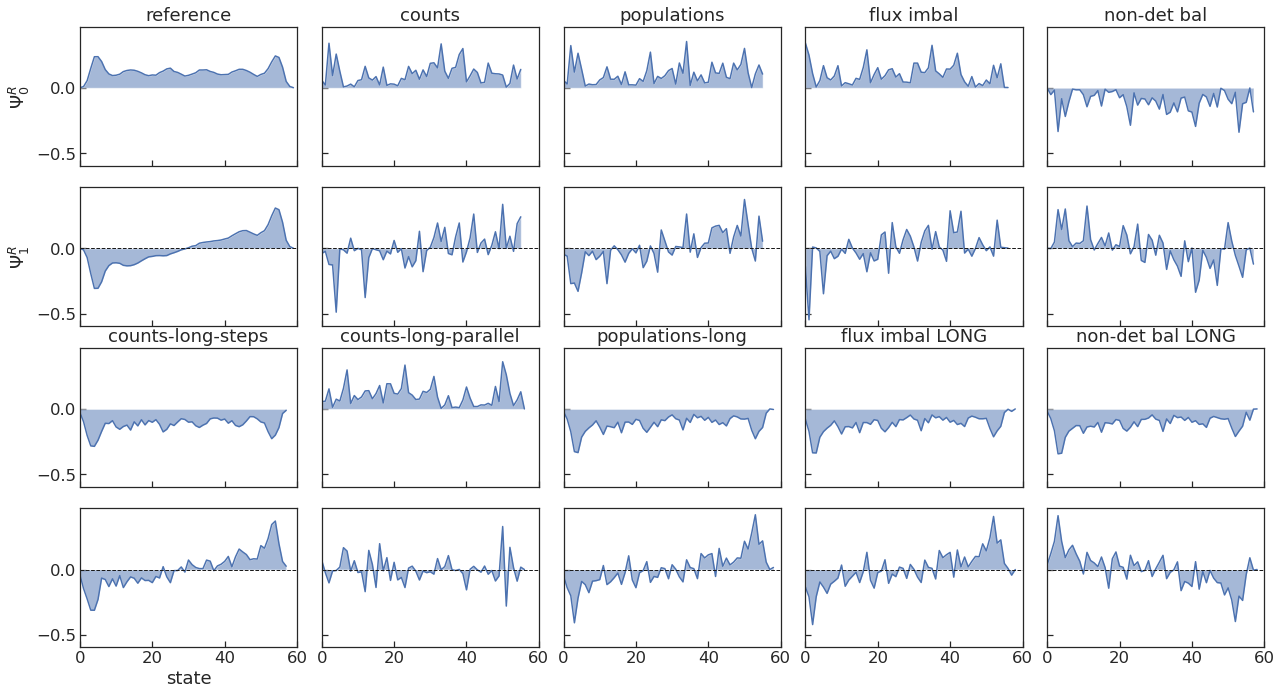

In [36]:
fig, ax = plt.subplots(4,5, sharex=True, sharey=True, figsize=(18,10))
plt.subplots_adjust(wspace=0.5, hspace=0.9)
ax[0,0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
ax[0,0].set_title('reference')
ax[1,0].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1,0].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)
# counts
ax[0,1].plot(-conc.anal.MSM.rvecsT[:,0])
ax[0,1].fill_between(range(len(conc.anal.MSM.rvecsT[:,0])), \
                   -conc.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,1].set_title('counts')
ax[1,1].plot(conc.anal.MSM.rvecsT[:,1])
ax[1,1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,1].fill_between(range(len(conc.anal.MSM.rvecsT[:,1])), \
                   conc.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# counts-long-steps (nsteps=50 instead of 15)
ax[2,0].plot(-conc_long.anal.MSM.rvecsT[:,0])
ax[2,0].fill_between(range(len(conc_long.anal.MSM.rvecsT[:,0])), \
                   -conc_long.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[2,0].set_title('counts-long-steps')
ax[3,0].plot(conc_long.anal.MSM.rvecsT[:,1])
ax[3,0].axhline(0,0,25, c='k', ls='--', lw=1)
ax[3,0].fill_between(range(len(conc_long.anal.MSM.rvecsT[:,1])), \
                   conc_long.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# counts-long-parallel (n_runs=14 instead of 4)
ax[2,1].plot(-conc_long_para.anal.MSM.rvecsT[:,0])
ax[2,1].fill_between(range(len(conc_long_para.anal.MSM.rvecsT[:,0])), \
                   -conc_long_para.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[2,1].set_title('counts-long-parallel')
ax[3,1].plot(conc_long_para.anal.MSM.rvecsT[:,1])
ax[3,1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[3,1].fill_between(range(len(conc_long_para.anal.MSM.rvecsT[:,1])), \
                   conc_long_para.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# populations
ax[0,2].plot(-conp.anal.MSM.rvecsT[:,0])
ax[0,2].fill_between(range(len(conp.anal.MSM.rvecsT[:,0])), \
                   -conp.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,2].set_title('populations')
ax[1,2].plot(conp.anal.MSM.rvecsT[:,1])
ax[1,2].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,2].fill_between(range(len(conp.anal.MSM.rvecsT[:,1])), \
                   conp.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# populations-long
ax[2,2].plot(-conp_long.anal.MSM.rvecsT[:,0])
ax[2,2].fill_between(range(len(conp_long.anal.MSM.rvecsT[:,0])), \
                   -conp_long.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[2,2].set_title('populations-long')
ax[3,2].plot(conp_long.anal.MSM.rvecsT[:,1])
ax[3,2].axhline(0,0,25, c='k', ls='--', lw=1)
ax[3,2].fill_between(range(len(conp_long.anal.MSM.rvecsT[:,1])), \
                   conp_long.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# flux
ax[0,3].plot(-conf.anal.MSM.rvecsT[:,0])
ax[0,3].fill_between(range(len(conf.anal.MSM.rvecsT[:,0])), \
                   -conf.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,3].set_title('flux imbal')
ax[1,3].plot(conf.anal.MSM.rvecsT[:,1])
ax[1,3].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,3].fill_between(range(len(conf.anal.MSM.rvecsT[:,1])), \
                   conf.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# flux-long
ax[2,3].plot(-conf_long.anal.MSM.rvecsT[:,0])
ax[2,3].fill_between(range(len(conf_long.anal.MSM.rvecsT[:,0])), \
                   -conf_long.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[2,3].set_title('flux imbal LONG')
ax[3,3].plot(conf_long.anal.MSM.rvecsT[:,1])
ax[3,3].axhline(0,0,25, c='k', ls='--', lw=1)
ax[3,3].fill_between(range(len(conf_long.anal.MSM.rvecsT[:,1])), \
                   conf_long.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# non-detailed balance
ax[0,4].plot(-condb.anal.MSM.rvecsT[:,0])
ax[0,4].fill_between(range(len(condb.anal.MSM.rvecsT[:,0])), \
                   -condb.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,4].set_title('non-det bal')
ax[1,4].plot(condb.anal.MSM.rvecsT[:,1])
ax[1,4].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,4].fill_between(range(len(condb.anal.MSM.rvecsT[:,1])), \
                   condb.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# non-detailed balance LONG
ax[2,4].plot(-condb_long.anal.MSM.rvecsT[:,0])
ax[2,4].fill_between(range(len(condb_long.anal.MSM.rvecsT[:,0])), \
                   -condb_long.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[2,4].set_title('non-det bal LONG')
ax[3,4].plot(condb_long.anal.MSM.rvecsT[:,1])
ax[3,4].axhline(0,0,25, c='k', ls='--', lw=1)
ax[3,4].fill_between(range(len(condb_long.anal.MSM.rvecsT[:,1])), \
                   condb_long.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# labels
ax[1,0].set_xlim(0,60)
ax[-1,0].set_xlabel("state")
#ax[1,0].set_xlabel("state"), ax[1,1].set_xlabel("state"), ax[1,2].set_xlabel("state"), ax[1,3].set_xlabel("state"), ax[1,4].set_xlabel("state")
ax[0,0].set_ylabel("$\Psi^R_0$")
ax[1,0].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

#### Test adaptive sampling - lag time relation for a fixed scoring

In [37]:
conp_long1 = controller.Controller(trajfiles=[h5file])
conp_long1.adaptive_sampling(16, 1, sym=False, rate_mat=False, \
        scoring='populations', n_epochs=20, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [ 0  0  0 59 59 59 59 59  0 59 59 33 59  0 59 59]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 33
not_run info: 0 11909 0
not_run info: 0 11909 0
not_run info: 0 5572 0
not_run info: 0 41128 59
not_run info: 0 10971 59
not_run info: 0 25451 59
not_run info: 0 38920 59
not_run info: 0 25451 59
not_run info: 0 5572 0
not_run info: 0 10971 59
not_run info: 0 41128 59
not_run info: 0 9004 33
not_run info: 0 41128 59
not_run info: 0 45989 0
not_run info: 0 41128 59
not_run info: 0 25451 59
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [57  0  0 57 47  0 54 54 36 18 13 57 48 49  0 37]
Building entry for microstate 57
Building entry for microstate 0
Building entry for microstate 47
Building entry for microstate 54
Building entry for microstate 36
Building entry for microstate 18
Building entry for microstate 13
Building entry for microstat

     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [57 36 10 43 17 57  1 10  0  0 56 57  9 21 57 56]
Building entry for microstate 57
Building entry for microstate 36
Building entry for microstate 10
Building entry for microstate 43
Building entry for microstate 17
Building entry for microstate 1
Building entry for microstate 0
Building entry for microstate 56
Building entry for microstate 9
Building entry for microstate 21
not_run info: 11 496 57
not_run info: 11 293 36
not_run info: 11 186 10
not_run info: 11 338 43
not_run info: 11 481 17
not_run info: 11 107 57
not_run info: 11 443 1
not_run info: 11 241 10
not_run info: 11 0 0
not_run info: 11 0 0
not_run info: 11 149 56
not_run info: 11 232 57
not_run info: 11 474 9
not_run info: 11 426 21
not_run info: 11 473 57
not_run info: 11 381 56
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [51 57 57 17  0 57 22 57 42 29 20  0 57 57 57 39]
Building entry for microstate 51
Building ent

In [38]:
conp_long20 = controller.Controller(trajfiles=[h5file])
conp_long20.adaptive_sampling(16, 20, sym=False, rate_mat=False, \
        scoring='populations', n_epochs=20, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [ 0 59  0  0  0 59 59  0 59 59 59 10 59 59 59  0]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 10
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 11909 0
not_run info: 0 5572 0
not_run info: 0 11909 0
not_run info: 0 10971 59
not_run info: 0 10971 59
not_run info: 0 11909 0
not_run info: 0 38920 59
not_run info: 0 38920 59
not_run info: 0 41128 59
not_run info: 0 9251 10
not_run info: 0 25451 59
not_run info: 0 10971 59
not_run info: 0 10971 59
not_run info: 0 11909 0
     # states: 60
MSM done
sum probabilities: 0.9999999999999999 58 58
Runs for new epoch: [42  0 33 57 12 43 22 57 57  0 57 31 57 33 40 28]
Building entry for microstate 42
Building entry for microstate 0
Building entry for microstate 33
Building entry for microstate 57
Building entry for microstate 12
Building entry for microstate 43
Building entry for microstate 22
Building entry

     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [57 27 57  8 57 57 51 57 57 57 57 57 57 57  7 57]
Building entry for microstate 57
Building entry for microstate 27
Building entry for microstate 8
Building entry for microstate 51
Building entry for microstate 7
not_run info: 11 311 57
not_run info: 11 301 27
not_run info: 11 183 57
not_run info: 11 226 8
not_run info: 11 254 57
not_run info: 11 245 57
not_run info: 11 447 51
not_run info: 11 267 57
not_run info: 11 285 57
not_run info: 11 98 57
not_run info: 11 340 57
not_run info: 11 18 57
not_run info: 11 155 57
not_run info: 11 285 57
not_run info: 11 46 7
not_run info: 11 134 57
     # states: 60
MSM done
sum probabilities: 1.0000000000000002 58 58
Runs for new epoch: [57 57 36 57 57 57 57 26 57 57  0 57 57 57  0  1]
Building entry for microstate 57
Building entry for microstate 36
Building entry for microstate 26
Building entry for microstate 0
Building entry for microstate 1
not_run info: 12 207 57
not_

In [39]:
conp_long40 = controller.Controller(trajfiles=[h5file])
conp_long40.adaptive_sampling(16, 40, sym=False, rate_mat=False, \
        scoring='populations', n_epochs=20, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0000000000000002 60 60
Runs for new epoch: [31 58  0 59 59 59 22  0 59 59 18 59  0  0  0  0]
Building entry for microstate 31
Building entry for microstate 58
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 22
Building entry for microstate 18
not_run info: 0 6952 31
not_run info: 0 11761 58
not_run info: 0 45989 0
not_run info: 0 38920 59
not_run info: 0 41128 59
not_run info: 0 38920 59
not_run info: 0 43165 22
not_run info: 0 45989 0
not_run info: 0 25451 59
not_run info: 0 10971 59
not_run info: 0 42568 18
not_run info: 0 10971 59
not_run info: 0 45989 0
not_run info: 0 45989 0
not_run info: 0 45989 0
not_run info: 0 11909 0
     # states: 60
MSM done
sum probabilities: 0.9999999999999999 59 59
Runs for new epoch: [56 57 57 17 57 57 56  7 57 58 57 57 57 15 57 57]
Building entry for microstate 56
Building entry for microstate 57
Building entry for microstate 17
Building entry for microstate

     # states: 60
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [57 57  5 57 57 57 57 57 57 57 57 57 57 57 57 57]
Building entry for microstate 57
Building entry for microstate 5
not_run info: 14 0 57
not_run info: 14 0 57
not_run info: 14 419 5
not_run info: 14 0 57
not_run info: 14 148 57
not_run info: 14 148 57
not_run info: 14 148 57
not_run info: 14 0 57
not_run info: 14 0 57
not_run info: 14 0 57
not_run info: 14 0 57
not_run info: 14 0 57
not_run info: 14 0 57
not_run info: 14 0 57
not_run info: 14 148 57
not_run info: 14 148 57
     # states: 60
MSM done
sum probabilities: 0.9999999999999999 59 59
Runs for new epoch: [57 57 57 57 57 57 57 57  0 57 57 57 57 57 57 57]
Building entry for microstate 57
Building entry for microstate 0
not_run info: 15 0 57
not_run info: 15 148 57
not_run info: 15 148 57
not_run info: 15 0 57
not_run info: 15 0 57
not_run info: 15 148 57
not_run info: 15 0 57
not_run info: 15 0 57
not_run info: 15 483 0
not_run info: 15 0 57
not_run info:

In [40]:
# NOTE I compare with msm_1D corresponding to lt=20
msm_1D.msms[20].tauT[0:1], \
conp_long1.anal.MSM.tauT[0:1], conp_long.anal.MSM.tauT[0:1], \
conp_long20.anal.MSM.tauT[0:1], conp_long40.anal.MSM.tauT[0:1]

([14.860639202395708],
 [14.734069513788752],
 [11.350358048038874],
 [14.148532261446165],
 [33.13952668583218])

In [41]:
len(msm_1D.msms[10].keys), \
len(conp_long1.anal.MSM.keys), len(conp_long.anal.MSM.keys), \
len(conp_long20.anal.MSM.keys), len(conp_long40.anal.MSM.keys)

(60, 60, 60, 60, 60)

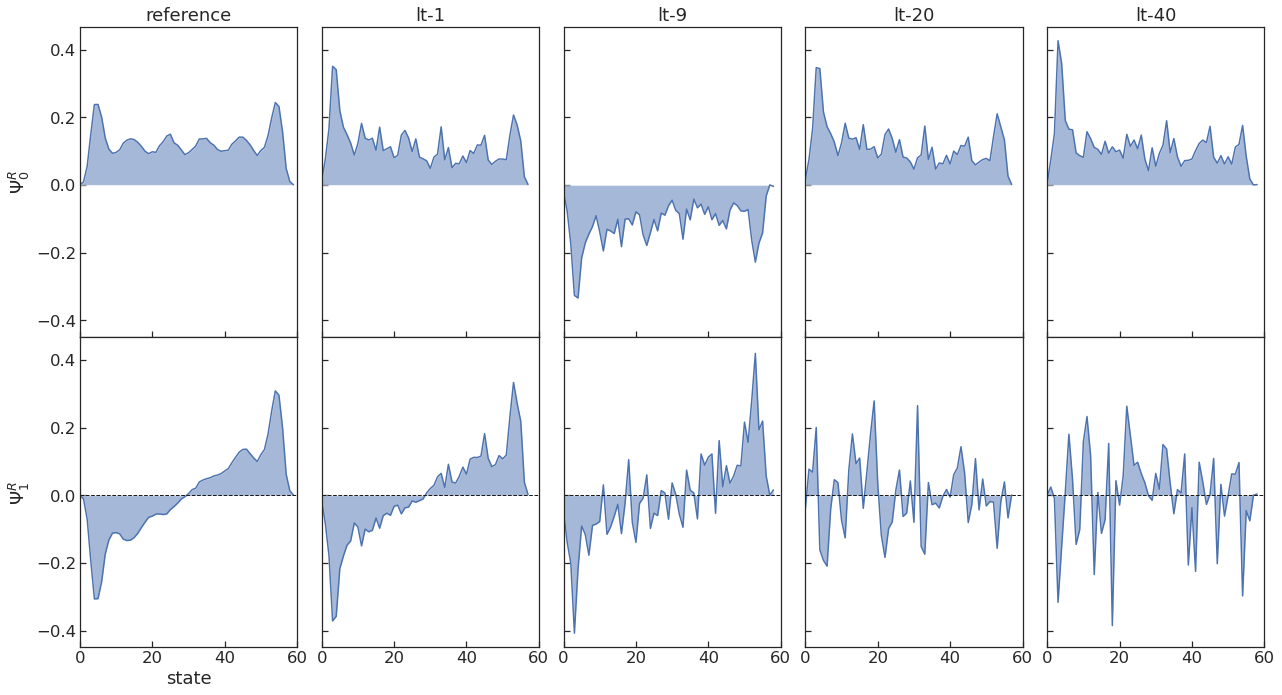

In [43]:
fig, ax = plt.subplots(2,5, sharex=True, sharey=True, figsize=(18,10))
plt.subplots_adjust(wspace=0.5, hspace=0.9)
ax[0,0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
ax[0,0].set_title('reference')
ax[1,0].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1,0].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)

# populations-long-lt-1
ax[0,1].plot(-conp_long1.anal.MSM.rvecsT[:,0])
ax[0,1].fill_between(range(len(conp_long1.anal.MSM.rvecsT[:,0])), \
                   -conp_long1.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,1].set_title('lt-1')
ax[1,1].plot(conp_long1.anal.MSM.rvecsT[:,1])
ax[1,1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,1].fill_between(range(len(conp_long1.anal.MSM.rvecsT[:,1])), \
                   conp_long1.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# populations-long-lt-9
ax[0,2].plot(-conp_long.anal.MSM.rvecsT[:,0])
ax[0,2].fill_between(range(len(conp_long.anal.MSM.rvecsT[:,0])), \
                   -conp_long.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,2].set_title('lt-9')
ax[1,2].plot(conp_long.anal.MSM.rvecsT[:,1])
ax[1,2].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,2].fill_between(range(len(conp_long.anal.MSM.rvecsT[:,1])), \
                   conp_long.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# populations-long-lt-20
ax[0,3].plot(-conp_long20.anal.MSM.rvecsT[:,0])
ax[0,3].fill_between(range(len(conp_long20.anal.MSM.rvecsT[:,0])), \
                   -conp_long20.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,3].set_title('lt-20')
ax[1,3].plot(conp_long20.anal.MSM.rvecsT[:,1])
ax[1,3].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,3].fill_between(range(len(conp_long20.anal.MSM.rvecsT[:,1])), \
                   conp_long20.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# populations-long-lagtime-40
ax[0,4].plot(-conp_long40.anal.MSM.rvecsT[:,0])
ax[0,4].fill_between(range(len(conp_long40.anal.MSM.rvecsT[:,0])), \
                   -conp_long40.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,4].set_title('lt-40')
ax[1,4].plot(conp_long40.anal.MSM.rvecsT[:,1])
ax[1,4].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,4].fill_between(range(len(conp_long40.anal.MSM.rvecsT[:,1])), \
                   conp_long40.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# labels
ax[1,0].set_xlim(0,60)
ax[-1,0].set_xlabel("state")
#ax[1,0].set_xlabel("state"), ax[1,1].set_xlabel("state"), ax[1,2].set_xlabel("state"), ax[1,3].set_xlabel("state"), ax[1,4].set_xlabel("state")
ax[0,0].set_ylabel("$\Psi^R_0$")
ax[1,0].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

### Check if adaptive-sampling converges to the reference

In [44]:
conp_ultralong = controller.Controller(trajfiles=[h5file])
conp_ultralong.adaptive_sampling(16, 9, sym=False, rate_mat=False, \
        scoring='populations', n_epochs=40, not_run=True, nsteps=1500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [ 0  0 59 59  0 35  0 44  0 59  0 59 59 59 59 59]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 35
Building entry for microstate 44
not_run info: 0 45989 0
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 10971 59
not_run info: 0 11909 0
not_run info: 0 28809 35
not_run info: 0 5572 0
not_run info: 0 8312 44
not_run info: 0 11909 0
not_run info: 0 38920 59
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 41128 59
not_run info: 0 25451 59
not_run info: 0 41128 59
not_run info: 0 25451 59
     # states: 60
MSM done
sum probabilities: 1.0000000000000002 59 59
Runs for new epoch: [ 0  0  0  0  0  0  0  1  0  0  0  0  1 42  0  0]
Building entry for microstate 0
Building entry for microstate 1
Building entry for microstate 42
not_run info: 1 938 0
not_run info: 1 0 0
not_run info: 1 0 0
not_run info: 1 0 0
not_run info: 1 938 0
not_run inf

     # states: 60
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Building entry for microstate 0
not_run info: 16 938 0
not_run info: 16 938 0
not_run info: 16 0 0
not_run info: 16 0 0
not_run info: 16 0 0
not_run info: 16 0 0
not_run info: 16 0 0
not_run info: 16 0 0
not_run info: 16 938 0
not_run info: 16 0 0
not_run info: 16 0 0
not_run info: 16 938 0
not_run info: 16 938 0
not_run info: 16 0 0
not_run info: 16 0 0
not_run info: 16 938 0
     # states: 60
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Building entry for microstate 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 938 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 0 0
not_run info: 17 938 0
not_run info: 17 0 0
not_run info: 17 938 0
     # states: 60
MSM done

     # states: 60
MSM done
sum probabilities: 1.0000000000000002 59 59
Runs for new epoch: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Building entry for microstate 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 0 0
not_run info: 33 938 0
     # states: 60
MSM done
sum probabilities: 0.9999999999999997 59 59
Runs for new epoch: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Building entry for microstate 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 938 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
not_run info: 34 0 0
     # sta

In [45]:
conc_ultralong = controller.Controller(trajfiles=[h5file])
conc_ultralong.adaptive_sampling(16, 9, sym=False, rate_mat=False, \
        scoring='counts', n_epochs=40, not_run=True, nsteps=1500)

     # states: 60
MSM done
sum probabilities: 1.0000000000000002 60 60
Runs for new epoch: [ 0  9  0  0  0 59  0  0 59  0 50 59  9 59  0 18]
Building entry for microstate 0
Building entry for microstate 9
Building entry for microstate 59
Building entry for microstate 50
Building entry for microstate 18
not_run info: 0 5572 0
not_run info: 0 2213 9
not_run info: 0 5572 0
not_run info: 0 11909 0
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 5572 0
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 11909 0
not_run info: 0 30006 50
not_run info: 0 25451 59
not_run info: 0 42827 9
not_run info: 0 38920 59
not_run info: 0 11909 0
not_run info: 0 49800 18
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [ 0 57 31 12  0 18 33  8  0  0 33  8 20 43  0 25]
Building entry for microstate 0
Building entry for microstate 57
Building entry for microstate 31
Building entry for microstate 12
Building entry for microstate 18
Building entry for mic

Building entry for microstate 0
Building entry for microstate 46
Building entry for microstate 47
Building entry for microstate 11
not_run info: 9 921 27
not_run info: 9 1 37
not_run info: 9 95 25
not_run info: 9 1218 48
not_run info: 9 687 55
not_run info: 9 1488 57
not_run info: 9 394 48
not_run info: 9 1198 49
not_run info: 9 952 57
not_run info: 9 1086 54
not_run info: 9 0 0
not_run info: 9 483 57
not_run info: 9 123 46
not_run info: 9 360 47
not_run info: 9 1436 37
not_run info: 9 181 11
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [36 27 47 56 17 18 14 24 47 47 15 57 52 26 57  0]
Building entry for microstate 36
Building entry for microstate 27
Building entry for microstate 47
Building entry for microstate 56
Building entry for microstate 17
Building entry for microstate 18
Building entry for microstate 14
Building entry for microstate 24
Building entry for microstate 15
Building entry for microstate 57
Building entry for microstate 52
Building entr

Building entry for microstate 56
Building entry for microstate 1
Building entry for microstate 17
Building entry for microstate 31
Building entry for microstate 54
Building entry for microstate 36
not_run info: 18 520 43
not_run info: 18 1166 32
not_run info: 18 0 0
not_run info: 18 462 35
not_run info: 18 1185 51
not_run info: 18 1328 57
not_run info: 18 294 48
not_run info: 18 513 57
not_run info: 18 241 56
not_run info: 18 331 48
not_run info: 18 688 1
not_run info: 18 1022 17
not_run info: 18 675 31
not_run info: 18 284 54
not_run info: 18 952 57
not_run info: 18 1415 36
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [39  8 18 57 43 19 15 40 51  1 37 41 19 39 15  6]
Building entry for microstate 39
Building entry for microstate 8
Building entry for microstate 18
Building entry for microstate 57
Building entry for microstate 43
Building entry for microstate 19
Building entry for microstate 15
Building entry for microstate 40
Building entry for microstate

Building entry for microstate 20
Building entry for microstate 51
Building entry for microstate 38
Building entry for microstate 14
Building entry for microstate 50
Building entry for microstate 39
Building entry for microstate 30
Building entry for microstate 34
not_run info: 27 0 0
not_run info: 27 1114 45
not_run info: 27 799 28
not_run info: 27 1062 21
not_run info: 27 1287 57
not_run info: 27 1200 20
not_run info: 27 146 51
not_run info: 27 0 0
not_run info: 27 1320 38
not_run info: 27 1120 14
not_run info: 27 297 57
not_run info: 27 546 50
not_run info: 27 633 39
not_run info: 27 1350 30
not_run info: 27 1440 57
not_run info: 27 1424 34
     # states: 60
MSM done
sum probabilities: 0.9999999999999999 58 58
Runs for new epoch: [34  0  0 49 18 56 22 36 15  7 24 48 48 36 26 55]
Building entry for microstate 34
Building entry for microstate 0
Building entry for microstate 49
Building entry for microstate 18
Building entry for microstate 56
Building entry for microstate 22
Building en

     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [ 8 45 57 51 57 14 17 57 40 29 57 16 35 57 11 32]
Building entry for microstate 8
Building entry for microstate 45
Building entry for microstate 57
Building entry for microstate 51
Building entry for microstate 14
Building entry for microstate 17
Building entry for microstate 40
Building entry for microstate 29
Building entry for microstate 16
Building entry for microstate 35
Building entry for microstate 11
Building entry for microstate 32
not_run info: 36 7 8
not_run info: 36 329 45
not_run info: 36 637 57
not_run info: 36 861 51
not_run info: 36 1424 57
not_run info: 36 553 14
not_run info: 36 1216 17
not_run info: 36 65 57
not_run info: 36 24 40
not_run info: 36 53 29
not_run info: 36 184 57
not_run info: 36 670 16
not_run info: 36 1489 35
not_run info: 36 394 57
not_run info: 36 888 11
not_run info: 36 945 32
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [ 0 45 57 54 16 57 57 

In [46]:
conf_ultralong = controller.Controller(trajfiles=[h5file])
conf_ultralong.adaptive_sampling(16, 9, sym=False, rate_mat=False, \
        scoring='flux', n_epochs=40, not_run=True, nsteps=1500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [34 45 33 19 19 10 56 33 37 32 45 55 34 56 32 56]
Building entry for microstate 34
Building entry for microstate 45
Building entry for microstate 33
Building entry for microstate 19
Building entry for microstate 10
Building entry for microstate 56
Building entry for microstate 37
Building entry for microstate 32
Building entry for microstate 55
not_run info: 0 16356 34
not_run info: 0 9112 45
not_run info: 0 13323 33
not_run info: 0 8349 19
not_run info: 0 30963 19
not_run info: 0 28906 10
not_run info: 0 40511 56
not_run info: 0 25466 33
not_run info: 0 43231 37
not_run info: 0 48808 32
not_run info: 0 38447 45
not_run info: 0 47413 55
not_run info: 0 3116 34
not_run info: 0 23576 56
not_run info: 0 23473 32
not_run info: 0 14339 56
     # states: 59
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [ 0 39 31  1 24  0  5 14 30 50 14  0 39 38 25  5]
Building entry for microstate 0
Building entry for mic

     # states: 59
MSM done
sum probabilities: 0.9999999999999999 59 59
Runs for new epoch: [40 31 15 31 14 10 43  5 38 55  9 19 17  7 55 40]
Building entry for microstate 40
Building entry for microstate 31
Building entry for microstate 15
Building entry for microstate 14
Building entry for microstate 10
Building entry for microstate 43
Building entry for microstate 5
Building entry for microstate 38
Building entry for microstate 55
Building entry for microstate 9
Building entry for microstate 19
Building entry for microstate 17
Building entry for microstate 7
not_run info: 9 1158 40
not_run info: 9 1344 31
not_run info: 9 816 15
not_run info: 9 895 31
not_run info: 9 933 14
not_run info: 9 782 10
not_run info: 9 677 43
not_run info: 9 409 5
not_run info: 9 1087 38
not_run info: 9 989 55
not_run info: 9 477 9
not_run info: 9 932 19
not_run info: 9 1203 17
not_run info: 9 418 7
not_run info: 9 1352 55
not_run info: 9 1494 40
     # states: 59
MSM done
sum probabilities: 1.00000000000000

     # states: 59
MSM done
sum probabilities: 0.9999999999999997 59 59
Runs for new epoch: [15 25 30 38  6 13 24 53 57 47 17 16  6 17 43  6]
Building entry for microstate 15
Building entry for microstate 25
Building entry for microstate 30
Building entry for microstate 38
Building entry for microstate 6
Building entry for microstate 13
Building entry for microstate 24
Building entry for microstate 53
Building entry for microstate 57
Building entry for microstate 47
Building entry for microstate 17
Building entry for microstate 16
Building entry for microstate 43
not_run info: 18 1092 15
not_run info: 18 380 25
not_run info: 18 640 30
not_run info: 18 418 38
not_run info: 18 460 6
not_run info: 18 722 13
not_run info: 18 126 24
not_run info: 18 1075 53
not_run info: 18 638 57
not_run info: 18 147 47
not_run info: 18 774 17
not_run info: 18 116 16
not_run info: 18 1202 6
not_run info: 18 117 17
not_run info: 18 1287 43
not_run info: 18 922 6
     # states: 59
MSM done
sum probabilities: 

     # states: 59
MSM done
sum probabilities: 1.0 59 59
Runs for new epoch: [49 15 21 13  6 25 36 55 10 33 35 10 17 16 17 57]
Building entry for microstate 49
Building entry for microstate 15
Building entry for microstate 21
Building entry for microstate 13
Building entry for microstate 6
Building entry for microstate 25
Building entry for microstate 36
Building entry for microstate 55
Building entry for microstate 10
Building entry for microstate 33
Building entry for microstate 35
Building entry for microstate 17
Building entry for microstate 16
Building entry for microstate 57
not_run info: 27 161 49
not_run info: 27 383 15
not_run info: 27 961 21
not_run info: 27 1031 13
not_run info: 27 1099 6
not_run info: 27 1480 25
not_run info: 27 68 36
not_run info: 27 1064 55
not_run info: 27 8 10
not_run info: 27 236 33
not_run info: 27 1226 35
not_run info: 27 259 10
not_run info: 27 820 17
not_run info: 27 380 16
not_run info: 27 731 17
not_run info: 27 199 57
     # states: 59
MSM done
s

Building entry for microstate 24
Building entry for microstate 40
Building entry for microstate 54
Building entry for microstate 51
not_run info: 35 407 11
not_run info: 35 1407 14
not_run info: 35 1269 12
not_run info: 35 1499 14
not_run info: 35 757 33
not_run info: 35 473 38
not_run info: 35 534 55
not_run info: 35 10 16
not_run info: 35 676 17
not_run info: 35 490 6
not_run info: 35 205 24
not_run info: 35 1118 40
not_run info: 35 1322 40
not_run info: 35 1197 54
not_run info: 35 707 6
not_run info: 35 284 51
     # states: 59
MSM done
sum probabilities: 1.0000000000000002 59 59
Runs for new epoch: [47 51 57  9  0  3 35  4 30 38 25 17 21  8 35  1]
Building entry for microstate 47
Building entry for microstate 51
Building entry for microstate 57
Building entry for microstate 9
Building entry for microstate 0
Building entry for microstate 3
Building entry for microstate 35
Building entry for microstate 4
Building entry for microstate 30
Building entry for microstate 38
Building entry

In [47]:
condb_ultralong = controller.Controller(trajfiles=[h5file])
condb_ultralong.adaptive_sampling(16, 9, sym=False, rate_mat=False, \
scoring='non_detailed_balance', n_epochs=40, not_run=True, nsteps=1500)

     # states: 60
MSM done
60 60
sum probabilities: 1.0000000000000002 60 60
Runs for new epoch: [ 6 44 11 30 18  7 47  8 21 49 48 58  7  3 11  8]
Building entry for microstate 6
Building entry for microstate 44
Building entry for microstate 11
Building entry for microstate 30
Building entry for microstate 18
Building entry for microstate 7
Building entry for microstate 47
Building entry for microstate 8
Building entry for microstate 21
Building entry for microstate 49
Building entry for microstate 48
Building entry for microstate 58
Building entry for microstate 3
not_run info: 0 12975 6
not_run info: 0 2239 44
not_run info: 0 17421 11
not_run info: 0 28244 30
not_run info: 0 40233 18
not_run info: 0 18138 7
not_run info: 0 38384 47
not_run info: 0 21579 8
not_run info: 0 26799 21
not_run info: 0 14460 49
not_run info: 0 42336 48
not_run info: 0 17047 58
not_run info: 0 21167 7
not_run info: 0 9969 3
not_run info: 0 25317 11
not_run info: 0 27639 8
     # states: 59
MSM done
59 59
sum

Building entry for microstate 17
Building entry for microstate 54
not_run info: 8 1170 15
not_run info: 8 1256 38
not_run info: 8 1068 51
not_run info: 8 1199 0
not_run info: 8 1082 10
not_run info: 8 1490 45
not_run info: 8 1190 4
not_run info: 8 710 28
not_run info: 8 76 21
not_run info: 8 1333 15
not_run info: 8 918 19
not_run info: 8 437 2
not_run info: 8 962 5
not_run info: 8 1476 17
not_run info: 8 701 17
not_run info: 8 345 54
     # states: 59
MSM done
59 59
sum probabilities: 0.9999999999999998 59 59
Runs for new epoch: [17 15 13 57 18 21 57 16 36 18  2 26 42 18 34 17]
Building entry for microstate 17
Building entry for microstate 15
Building entry for microstate 13
Building entry for microstate 57
Building entry for microstate 18
Building entry for microstate 21
Building entry for microstate 16
Building entry for microstate 36
Building entry for microstate 2
Building entry for microstate 26
Building entry for microstate 42
Building entry for microstate 34
not_run info: 9 1205

     # states: 59
MSM done
59 59
sum probabilities: 1.0000000000000002 59 59
Runs for new epoch: [ 2 22 23 39 26 51 44 14 46 30 28 45 42 55 14 14]
Building entry for microstate 2
Building entry for microstate 22
Building entry for microstate 23
Building entry for microstate 39
Building entry for microstate 26
Building entry for microstate 51
Building entry for microstate 44
Building entry for microstate 14
Building entry for microstate 46
Building entry for microstate 30
Building entry for microstate 28
Building entry for microstate 45
Building entry for microstate 42
Building entry for microstate 55
not_run info: 17 1066 2
not_run info: 17 338 22
not_run info: 17 907 23
not_run info: 17 1337 39
not_run info: 17 1105 26
not_run info: 17 234 51
not_run info: 17 275 44
not_run info: 17 645 14
not_run info: 17 1056 46
not_run info: 17 913 30
not_run info: 17 178 28
not_run info: 17 1249 45
not_run info: 17 883 42
not_run info: 17 1159 55
not_run info: 17 904 14
not_run info: 17 332 14
   

Building entry for microstate 31
Building entry for microstate 19
Building entry for microstate 39
Building entry for microstate 8
not_run info: 25 258 38
not_run info: 25 242 54
not_run info: 25 1157 49
not_run info: 25 810 34
not_run info: 25 754 42
not_run info: 25 477 36
not_run info: 25 727 40
not_run info: 25 246 5
not_run info: 25 533 41
not_run info: 25 443 35
not_run info: 25 237 31
not_run info: 25 184 19
not_run info: 25 1136 39
not_run info: 25 694 8
not_run info: 25 1491 40
not_run info: 25 766 54
     # states: 59
MSM done
59 59
sum probabilities: 1.0 59 59
Runs for new epoch: [24 19 33 29 18 51  7 48 51 33 40  8 44 28 38 34]
Building entry for microstate 24
Building entry for microstate 19
Building entry for microstate 33
Building entry for microstate 29
Building entry for microstate 18
Building entry for microstate 51
Building entry for microstate 7
Building entry for microstate 48
Building entry for microstate 40
Building entry for microstate 8
Building entry for micro

     # states: 59
MSM done
59 59
sum probabilities: 0.9999999999999999 59 59
Runs for new epoch: [54 49  9 28 50 48  0 29 32 56  9 11 42  6 14  4]
Building entry for microstate 54
Building entry for microstate 49
Building entry for microstate 9
Building entry for microstate 28
Building entry for microstate 50
Building entry for microstate 48
Building entry for microstate 0
Building entry for microstate 29
Building entry for microstate 32
Building entry for microstate 56
Building entry for microstate 11
Building entry for microstate 42
Building entry for microstate 6
Building entry for microstate 14
Building entry for microstate 4
not_run info: 34 120 54
not_run info: 34 696 49
not_run info: 34 1169 9
not_run info: 34 689 28
not_run info: 34 560 50
not_run info: 34 988 48
not_run info: 34 577 0
not_run info: 34 611 29
not_run info: 34 440 32
not_run info: 34 844 56
not_run info: 34 1127 9
not_run info: 34 665 11
not_run info: 34 618 42
not_run info: 34 1059 6
not_run info: 34 864 14
not

In [48]:
# NOTE I compare with msm_1D corresponding to lt=20
msm_1D.msms[20].tauT[0:1], \
conc_ultralong.anal.MSM.tauT[0:1], \
conp_ultralong.anal.MSM.tauT[0:1], \
conf_ultralong.anal.MSM.tauT[0:1], \
condb_ultralong.anal.MSM.tauT[0:1]

([14.860639202395708],
 [14.20620018950436],
 [14.178685721827362],
 [14.210707803740332],
 [14.224409348373763])

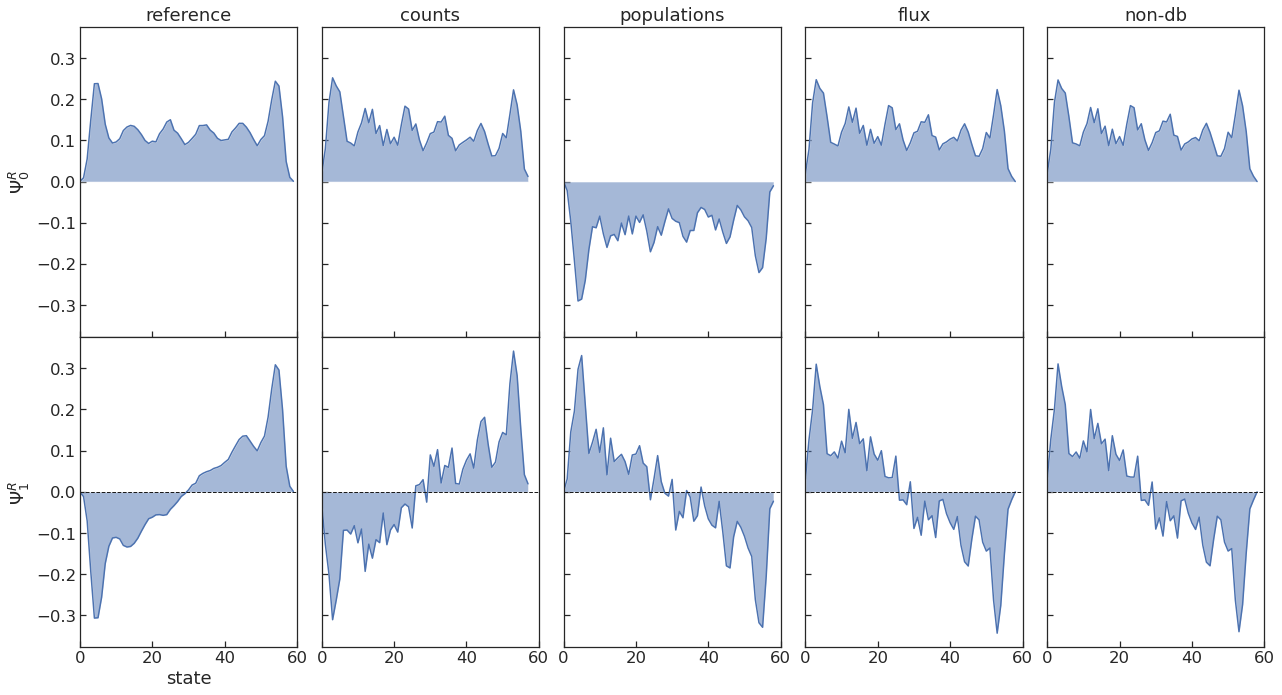

In [49]:
fig, ax = plt.subplots(2,5, sharex=True, sharey=True, figsize=(18,10))
plt.subplots_adjust(wspace=0.5, hspace=0.9)
ax[0,0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
ax[0,0].set_title('reference')
ax[1,0].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1,0].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)

# counts ultralong
ax[0,1].plot(-conc_ultralong.anal.MSM.rvecsT[:,0])
ax[0,1].fill_between(range(len(conc_ultralong.anal.MSM.rvecsT[:,0])), \
                -conc_ultralong.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,1].set_title('counts')
ax[1,1].plot(conc_ultralong.anal.MSM.rvecsT[:,1])
ax[1,1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1,1].fill_between(range(len(conc_ultralong.anal.MSM.rvecsT[:,1])), \
                conc_ultralong.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# populations ultralong
ax[0,2].plot(-conp_ultralong.anal.MSM.rvecsT[:,0])
ax[0,2].fill_between(range(len(conp_ultralong.anal.MSM.rvecsT[:,0])), \
                -conp_ultralong.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,2].set_title('populations')
ax[1,2].plot(conp_ultralong.anal.MSM.rvecsT[:,1])
ax[1,2].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,2].fill_between(range(len(conp_ultralong.anal.MSM.rvecsT[:,1])), \
                conp_ultralong.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# flux imbalance ultralong
ax[0,3].plot(-conf_ultralong.anal.MSM.rvecsT[:,0])
ax[0,3].fill_between(range(len(conf_ultralong.anal.MSM.rvecsT[:,0])), \
                   -conf_ultralong.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,3].set_title('flux')
ax[1,3].plot(conf_ultralong.anal.MSM.rvecsT[:,1])
ax[1,3].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,3].fill_between(range(len(conf_ultralong.anal.MSM.rvecsT[:,1])), \
                   conf_ultralong.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# non detailed balance ultralong
ax[0,4].plot(-condb_ultralong.anal.MSM.rvecsT[:,0])
ax[0,4].fill_between(range(len(condb_ultralong.anal.MSM.rvecsT[:,0])), \
                -condb_ultralong.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,4].set_title('non-db')
ax[1,4].plot(condb_ultralong.anal.MSM.rvecsT[:,1])
ax[1,4].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,4].fill_between(range(len(condb_ultralong.anal.MSM.rvecsT[:,1])), \
                condb_ultralong.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# labels
ax[1,0].set_xlim(0,60)
ax[-1,0].set_xlabel("state")
#ax[1,0].set_xlabel("state"), ax[1,1].set_xlabel("state"), ax[1,2].set_xlabel("state"), ax[1,3].set_xlabel("state"), ax[1,4].set_xlabel("state")
ax[0,0].set_ylabel("$\Psi^R_0$")
ax[1,0].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

RUN adaptive sampling with overall equal steps as reference MSM. Do it for many parameter selection (lagtime, scoring, bins?).

In [54]:
conc_same = controller.Controller(trajfiles=[h5file])
conc_same.adaptive_sampling(10, 9, sym=False, \
 rate_mat=False, scoring='counts', n_epochs=10, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0000000000000002 60 60
Runs for new epoch: [38  0 59 59  0  0 59 59 19  0]
Building entry for microstate 38
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 19
not_run info: 0 17695 38
not_run info: 0 11909 0
not_run info: 0 41128 59
not_run info: 0 10971 59
not_run info: 0 11909 0
not_run info: 0 45989 0
not_run info: 0 41128 59
not_run info: 0 41128 59
not_run info: 0 28945 19
not_run info: 0 11909 0
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [42 56  4 10  5 57  6 19 55 57]
Building entry for microstate 42
Building entry for microstate 56
Building entry for microstate 4
Building entry for microstate 10
Building entry for microstate 5
Building entry for microstate 57
Building entry for microstate 6
Building entry for microstate 19
Building entry for microstate 55
not_run info: 1 334 42
not_run info: 1 351 56
not_run info: 1 184 4
not_run info: 1 127 10
not_run

In [55]:
conp_same = controller.Controller(trajfiles=[h5file])
conp_same.adaptive_sampling(10, 9, sym=False, \
 rate_mat=False, scoring='populations', n_epochs=10, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [ 0 59 59  0  0 59  0 59 59  0]
Building entry for microstate 0
Building entry for microstate 59
not_run info: 0 5572 0
not_run info: 0 41128 59
not_run info: 0 25451 59
not_run info: 0 45989 0
not_run info: 0 45989 0
not_run info: 0 41128 59
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 38920 59
not_run info: 0 45989 0
     # states: 60
MSM done
sum probabilities: 1.0000000000000002 58 58
Runs for new epoch: [40 11 51 26 26 57 57 27 23 25]
Building entry for microstate 40
Building entry for microstate 11
Building entry for microstate 51
Building entry for microstate 26
Building entry for microstate 57
Building entry for microstate 27
Building entry for microstate 23
Building entry for microstate 25
not_run info: 1 234 40
not_run info: 1 196 11
not_run info: 1 361 51
not_run info: 1 326 26
not_run info: 1 147 26
not_run info: 1 314 57
not_run info: 1 253 57
not_run info: 1 329 27
not_run info:

In [56]:
conf_same = controller.Controller(trajfiles=[h5file])
conf_same.adaptive_sampling(10, 9, sym=False, \
 rate_mat=False, scoring='flux', n_epochs=10, not_run=True, nsteps=500)

     # states: 60
MSM done
sum probabilities: 1.0 60 60
Runs for new epoch: [45 37 19  5 56 45 37 55 35 18]
Building entry for microstate 45
Building entry for microstate 37
Building entry for microstate 19
Building entry for microstate 5
Building entry for microstate 56
Building entry for microstate 55
Building entry for microstate 35
Building entry for microstate 18
not_run info: 0 43577 45
not_run info: 0 29357 37
not_run info: 0 4550 19
not_run info: 0 43885 5
not_run info: 0 28799 56
not_run info: 0 44560 45
not_run info: 0 18894 37
not_run info: 0 298 55
not_run info: 0 14559 35
not_run info: 0 16154 18
     # states: 58
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [34 57 13  3 57  6 27 57 57 13]
Building entry for microstate 34
Building entry for microstate 57
Building entry for microstate 13
Building entry for microstate 3
Building entry for microstate 6
Building entry for microstate 27
not_run info: 1 221 34
not_run info: 1 497 57
not_run info: 1 479 13
not_run in

In [57]:
condb_same = controller.Controller(trajfiles=[h5file])
condb_same.adaptive_sampling(10, 9, sym=False, \
 rate_mat=False, scoring='non_detailed_balance', n_epochs=10, not_run=True, nsteps=500)

     # states: 60
MSM done
60 60
sum probabilities: 1.0000000000000002 60 60
Runs for new epoch: [ 8 28 56 58 50 40  3 15 13 12]
Building entry for microstate 8
Building entry for microstate 28
Building entry for microstate 56
Building entry for microstate 58
Building entry for microstate 50
Building entry for microstate 40
Building entry for microstate 3
Building entry for microstate 15
Building entry for microstate 13
Building entry for microstate 12
not_run info: 0 6156 8
not_run info: 0 1652 28
not_run info: 0 8758 56
not_run info: 0 31840 58
not_run info: 0 9916 50
not_run info: 0 46589 40
not_run info: 0 41382 3
not_run info: 0 33850 15
not_run info: 0 3694 13
not_run info: 0 21624 12
     # states: 58
MSM done
58 58
sum probabilities: 1.0 58 58
Runs for new epoch: [32  5 33  2  7 23 27  8 34 37]
Building entry for microstate 32
Building entry for microstate 5
Building entry for microstate 33
Building entry for microstate 2
Building entry for microstate 7
Building entry for micro

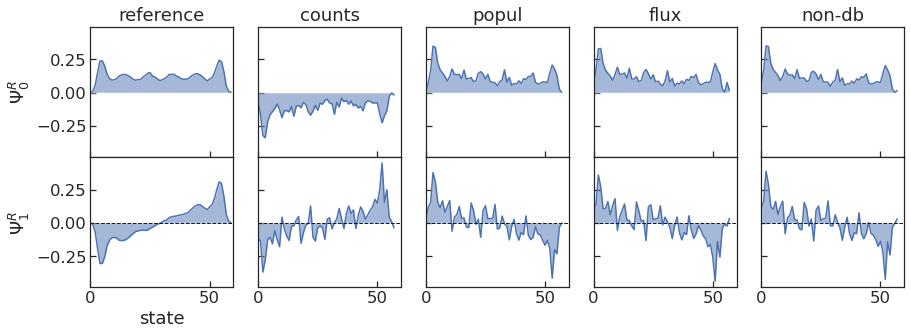

In [58]:
fig, ax = plt.subplots(2,5, sharex=True, sharey=True, figsize=(13,5))
plt.subplots_adjust(wspace=0.5, hspace=0.9)
ax[0,0].plot(-msm_1D.msms[1].rvecsT[:,0])
ax[0,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,0])), \
                   -msm_1D.msms[1].rvecsT[:,0], 0, alpha=0.5)
ax[0,0].set_title('reference')
ax[1,0].plot(msm_1D.msms[1].rvecsT[:,1])
ax[1,0].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,0].fill_between(range(len(msm_1D.msms[1].rvecsT[:,1])), \
                   msm_1D.msms[1].rvecsT[:,1], 0, alpha=0.5)

# counts
ax[0,1].plot(-conc_same.anal.MSM.rvecsT[:,0])
ax[0,1].fill_between(range(len(conc_same.anal.MSM.rvecsT[:,0])), \
        -conc_same.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,1].set_title('counts')
ax[1,1].plot(conc_same.anal.MSM.rvecsT[:,1])
ax[1,1].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,1].fill_between(range(len(conc_same.anal.MSM.rvecsT[:,1])), \
        conc_same.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# populations
ax[0,2].plot(-conp_same.anal.MSM.rvecsT[:,0])
ax[0,2].fill_between(range(len(conp_same.anal.MSM.rvecsT[:,0])), \
                                -conp_same.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,2].set_title('popul')
ax[1,2].plot(conp_same.anal.MSM.rvecsT[:,1])
ax[1,2].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,2].fill_between(range(len(conp_same.anal.MSM.rvecsT[:,1])), \
                                conp_same.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# flux
ax[0,3].plot(-conf_same.anal.MSM.rvecsT[:,0])
ax[0,3].fill_between(range(len(conf_same.anal.MSM.rvecsT[:,0])), \
                               -conf_same.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,3].set_title('flux')
ax[1,3].plot(conf_same.anal.MSM.rvecsT[:,1])
ax[1,3].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,3].fill_between(range(len(conf_same.anal.MSM.rvecsT[:,1])), \
                               conf_same.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# non detailed balance
ax[0,4].plot(-condb_same.anal.MSM.rvecsT[:,0])
ax[0,4].fill_between(range(len(condb_same.anal.MSM.rvecsT[:,0])), \
                                -condb_same.anal.MSM.rvecsT[:,0], 0, alpha=0.5)
ax[0,4].set_title('non-db')
ax[1,4].plot(condb_same.anal.MSM.rvecsT[:,1])
ax[1,4].axhline(0,0,45, c='k', ls='--', lw=1)
ax[1,4].fill_between(range(len(condb_same.anal.MSM.rvecsT[:,1])), \
                                condb_same.anal.MSM.rvecsT[:,1], 0, alpha=0.5)

# labels
ax[1,0].set_xlim(0,60)
ax[-1,0].set_xlabel("state")
#ax[1,0].set_xlabel("state"), ax[1,1].set_xlabel("state"), ax[1,2].set_xlabel("state"), ax[1,3].set_xlabel("state"), ax[1,4].set_xlabel("state")
ax[0,0].set_ylabel("$\Psi^R_0$")
ax[1,0].set_ylabel("$\Psi^R_1$")
plt.tight_layout(h_pad=0)

In [59]:
# NOTE I compare with msm_1D corresponding to lt=20
msm_1D.msms[20].tauT[0:1], conc_same.anal.MSM.tauT[0:1], \
conp_same.anal.MSM.tauT[0:1], conf_same.anal.MSM.tauT[0:1], condb_same.anal.MSM.tauT[0:1]

([14.860639202395708],
 [11.05403535734827],
 [11.3852743555481],
 [11.07128670178097],
 [10.866919873177304])

# RELATIVE ENTROPY

In [60]:
def pseudomatrix(MSMp):
    pseudo  = np.zeros((len(MSMp.peqT),len(MSMp.peqT)))
    pseudo += 0.001/ float(len(MSMp.peqT))
    return pseudo

In [61]:
def relative_entropy(MSMp, pmat, qmat):
    # MSMp for reference, qmat for test
    # see Bowman et al. PNAS 2010
    entropy = 0.0
    for i in range(0,len(MSMp.peqT)):
        for j in range(0,len(MSMp.peqT)):
            aux = np.log(pmat[i,j]/qmat[i,j])
            entropy += MSMp.peqT[i]*pmat[i,j]*aux
    return entropy

In [62]:
#condb_same.adaptive_sampling(10, 9, sym=False, \
# rate_mat=False, scoring='non_detailed_balance', n_epochs=10, not_run=True, nsteps=500)
conctest = []
for nsteps in np.arange(100,1000,100):
    conc = controller.Controller(trajfiles=[h5file])
    conc.adaptive_sampling(10, 10, sym=False, rate_mat=False, \
        scoring='counts', n_epochs=10, not_run=True, nsteps=nsteps)
    conctest.append(conc)

     # states: 60
MSM done
sum probabilities: 0.9999999999999998 60 60
Runs for new epoch: [ 0 59 59 59 35  0 59 34 59 59]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 35
Building entry for microstate 34
not_run info: 0 45989 0
not_run info: 0 41128 59
not_run info: 0 10971 59
not_run info: 0 38920 59
not_run info: 0 43831 35
not_run info: 0 5572 0
not_run info: 0 38920 59
not_run info: 0 39529 34
not_run info: 0 41128 59
not_run info: 0 25451 59
     # states: 58
MSM done
sum probabilities: 1.0 56 56
Runs for new epoch: [45 27 52 36 23 23 55 44 52 55]
Building entry for microstate 45
Building entry for microstate 27
Building entry for microstate 52
Building entry for microstate 36
Building entry for microstate 23
Building entry for microstate 55
Building entry for microstate 44
not_run info: 1 54 45
not_run info: 1 43 27
not_run info: 1 61 52
not_run info: 1 38 36
not_run info: 1 69 23
not_run info: 1 14 23
not_run info: 1 77 55
not_ru

MSM done
sum probabilities: 1.0000000000000002 58 58
Runs for new epoch: [57 20 57  3 57 57 56 57 57 57]
Building entry for microstate 57
Building entry for microstate 20
Building entry for microstate 3
Building entry for microstate 56
not_run info: 3 9 57
not_run info: 3 93 20
not_run info: 3 123 57
not_run info: 3 97 3
not_run info: 3 9 57
not_run info: 3 116 57
not_run info: 3 152 56
not_run info: 3 100 57
not_run info: 3 53 57
not_run info: 3 116 57
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [ 8 56 57 56 57 46 57 43 57 57]
Building entry for microstate 8
Building entry for microstate 56
Building entry for microstate 57
Building entry for microstate 46
Building entry for microstate 43
not_run info: 4 79 8
not_run info: 4 90 56
not_run info: 4 53 57
not_run info: 4 93 56
not_run info: 4 100 57
not_run info: 4 18 46
not_run info: 4 199 57
not_run info: 4 179 43
not_run info: 4 48 57
not_run info: 4 100 57
     # states: 60
MSM done
sum probabilities: 0

     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [57 57 55 57 57 56 57 57 57 57]
Building entry for microstate 57
Building entry for microstate 55
Building entry for microstate 56
not_run info: 10 0 57
not_run info: 10 0 57
not_run info: 10 224 55
not_run info: 10 0 57
not_run info: 10 0 57
not_run info: 10 138 56
not_run info: 10 0 57
not_run info: 10 0 57
not_run info: 10 0 57
not_run info: 10 0 57
     # states: 60
MSM done
sum probabilities: 0.9999999999999998 60 60
Runs for new epoch: [ 0 59 58 59 59 59  0  0 59  0]
Building entry for microstate 0
Building entry for microstate 59
Building entry for microstate 58
not_run info: 0 5572 0
not_run info: 0 10971 59
not_run info: 0 30889 58
not_run info: 0 25451 59
not_run info: 0 41128 59
not_run info: 0 10971 59
not_run info: 0 45989 0
not_run info: 0 45989 0
not_run info: 0 38920 59
not_run info: 0 5572 0
     # states: 60
MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [13 57 56 57 21 36 18 56 51 

MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [57 57 57 57 11 57  0 18 57 57]
Building entry for microstate 57
Building entry for microstate 11
Building entry for microstate 0
Building entry for microstate 18
not_run info: 5 0 57
not_run info: 5 0 57
not_run info: 5 0 57
not_run info: 5 0 57
not_run info: 5 408 11
not_run info: 5 0 57
not_run info: 5 166 0
not_run info: 5 170 18
not_run info: 5 0 57
not_run info: 5 0 57
     # states: 60
MSM done
sum probabilities: 0.9999999999999998 58 58
Runs for new epoch: [ 0  8 57 48 51 57 57 57 56  6]
Building entry for microstate 0
Building entry for microstate 8
Building entry for microstate 57
Building entry for microstate 48
Building entry for microstate 51
Building entry for microstate 56
Building entry for microstate 6
not_run info: 6 306 0
not_run info: 6 470 8
not_run info: 6 0 57
not_run info: 6 358 48
not_run info: 6 464 51
not_run info: 6 0 57
not_run info: 6 0 57
not_run info: 6 0 57
not_run info: 6 362 56
not_run info: 6 

MSM done
sum probabilities: 1.0 58 58
Runs for new epoch: [ 2  0  0  9 17 51 39 32 47 14]
Building entry for microstate 2
Building entry for microstate 0
Building entry for microstate 9
Building entry for microstate 17
Building entry for microstate 51
Building entry for microstate 39
Building entry for microstate 32
Building entry for microstate 47
Building entry for microstate 14
not_run info: 1 281 2
not_run info: 1 534 0
not_run info: 1 396 0
not_run info: 1 669 9
not_run info: 1 364 17
not_run info: 1 440 51
not_run info: 1 667 39
not_run info: 1 473 32
not_run info: 1 50 47
not_run info: 1 412 14
     # states: 60
MSM done
sum probabilities: 0.9999999999999998 58 58
Runs for new epoch: [57 57 17 29 30 21 56 36  0 26]
Building entry for microstate 57
Building entry for microstate 17
Building entry for microstate 29
Building entry for microstate 30
Building entry for microstate 21
Building entry for microstate 56
Building entry for microstate 36
Building entry for microstate 0
Build

MSM done
sum probabilities: 0.9999999999999999 58 58
Runs for new epoch: [29 16 35 56 57 52 10  9 56 33]
Building entry for microstate 29
Building entry for microstate 16
Building entry for microstate 35
Building entry for microstate 56
Building entry for microstate 57
Building entry for microstate 52
Building entry for microstate 10
Building entry for microstate 9
Building entry for microstate 33
not_run info: 4 26 29
not_run info: 4 262 16
not_run info: 4 755 35
not_run info: 4 577 56
not_run info: 4 0 57
not_run info: 4 395 52
not_run info: 4 65 10
not_run info: 4 314 9
not_run info: 4 339 56
not_run info: 4 369 33
     # states: 60
MSM done
sum probabilities: 1.0000000000000002 58 58
Runs for new epoch: [25 56 56 24  9 50 21  4 56 20]
Building entry for microstate 25
Building entry for microstate 56
Building entry for microstate 24
Building entry for microstate 9
Building entry for microstate 50
Building entry for microstate 21
Building entry for microstate 4
Building entry for mic

     # states: 60
MSM done
sum probabilities: 0.9999999999999999 59 59
Runs for new epoch: [58 58 58 58 58 58 58 58 58 58]
Building entry for microstate 58
not_run info: 10 209 58
not_run info: 10 611 58
not_run info: 10 80 58
not_run info: 10 97 58
not_run info: 10 351 58
not_run info: 10 882 58
not_run info: 10 368 58
not_run info: 10 639 58
not_run info: 10 790 58
not_run info: 10 599 58


In [63]:
#conctest[0].anal.MSM.keys, conctest[0].anal.MSM.keep_states

In [64]:
ent = []
for obj in conctest:
    pmat = pseudomatrix(msm_1D.msms[lt])
    # para evitar los zeros, añadimos pseudo a la matriz de referencia
    rmat = msm_1D.msms[lt].trans + pmat
    # por si no hemos visitado todos estados, añadimos el pseudo al que queremos testear
    for i in range(0,len(obj.anal.MSM.peqT)):
        for j in range(0,len(obj.anal.MSM.peqT)):
            pmat[i,j] += obj.anal.MSM.trans[i,j]
    
    # compute entropy
    ent.append(relative_entropy(msm_1D.msms[lt], rmat, pmat))

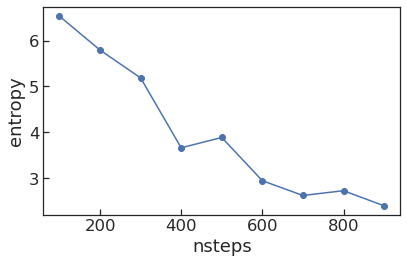

In [65]:
fig, ax = plt.subplots()
ax.plot(np.arange(100,1000,100),ent,'o-')
ax.set_xlabel('nsteps')
ax.set_ylabel('entropy')
#ax.set_yscale('log')
plt.tight_layout()